In [1]:
# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "all"

In [2]:
import numpy as np
import scipy
import time
import sys
import scipy.io
import pandas as pd
from scipy.stats import uniform
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor

from sklearn import linear_model
import matplotlib.pyplot as plt

from utilities import *
from partition_class import *

In [3]:
def friedman(dim=2,n=1000):
    """
    2d altererd version of friedman function.
    """
    xdata = uniform.rvs(size=(n, dim))  # uniform sample
    
    ydata = (10*np.sin(xdata[:, 0]*np.pi*xdata[:, 1]) + norm.rvs(size=n))   # sample from standard normal

    return xdata,ydata

def rastrigin(dim=2,n=1000):
    """
    Rastrigin test objective function, shifted by 10. units away from origin
    """
    x = uniform.rvs(size=(n, dim))  # uniform sample
    x = x*10 - 5
    x = np.copy(x)
    if not np.isscalar(x[0]):
        N = len(x[0])
        y = -np.array([10 * N + sum(xi**2 - 10 * np.cos(2 * np.pi * xi)) for xi in x])
    x = (x+5)/10
    y = (y-np.mean(y))/(np.max(y) - np.min(y))
    return x,y

def custom1(n=1000):
    """
    Custom function defined by Lucas.
    """
    box1=np.array([[0,0.5], [0,0.5]])
    box2=np.array([[0.5,1],[0.5,1]])
    omega1=200
    omega2=100 
    np.random.seed(0)
    x1=np.random.uniform(0,1,n)
    x2=np.random.uniform(0,1,n)
    sigma=1
    y=np.zeros(n)
    for i in range (n):
        if  x1[i]<0.5 and x2[i]<0.5:
            y[i]=np.random.normal(omega1,sigma)
        elif x1[i]>0.5 and x2[i]>0.5:
            y[i]=np.random.normal(omega2,sigma)
        else:
            y[i]=np.random.normal(0,sigma)

    #generate samples from the true parameters

    x=np.array([x1,x2])
    x=np.transpose(x)
    x.reshape(n,2)
    
    y = (y-np.mean(y))/(np.max(y) - np.min(y))
    return x,y

In [4]:
# parameters
dataNum = 10000
dimNum = 2
lambdas = 2
taus = 1

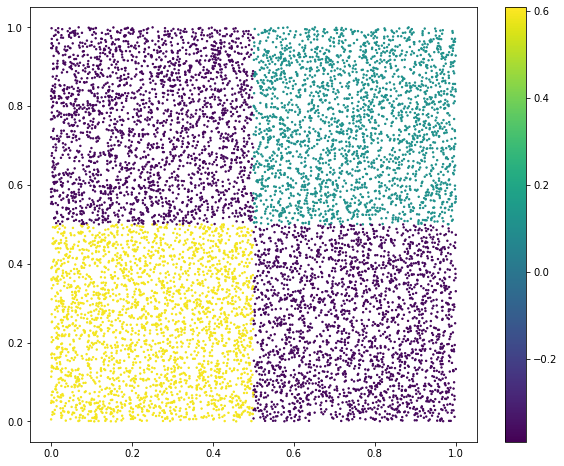

In [5]:
# Generate X and y training data (data)
# xdata, ydata = rastrigin(dimNum, dataNum)
xdata,ydata = custom1(dataNum)

def plot_data(x,y):
    import matplotlib.pyplot as plt
    plt.figure(figsize=(10,8))
    plt.scatter(x[:,0], x[:,1], cmap='viridis', c=y, s=2)
    plt.colorbar()
    plt.show()
    
plot_data(xdata,ydata)

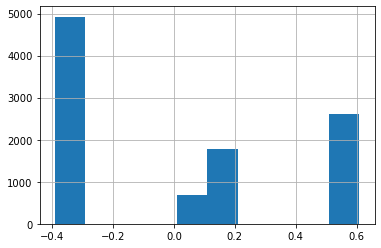

In [6]:
pd.Series(ydata).hist()

### Initialise data and RBP objects

In [7]:
# Generate X and y training data (data)
xdata, ydata = custom1(dataNum)

# Split the data into train and test with ratio 50/50
train_test_ratio = 0.5 # the ratio of test data

# preprocess data
(xdata_train, ydata_train,              # training set
xdata_test, ydata_test,                 # testing set
ydata_train_mean, dd,                   # mean
hyper_sigma_1, hyper_sigma_2,           # variance of the prior
variance_hat) = pre_process_data(xdata, ydata, train_test_ratio) # expected variance

# the length vector for all the dimensions
dimLength = np.ones(dimNum)*1.0

# number of iterations to run algorithm
IterationTime = 1000

# Initialise the RBP
RBP = PartitionPatch(dimLength, dataNum, taus, lambdas, np.mean(ydata_train), variance_hat)

# patchnum = int(taus * np.prod(1 + lambdas * dimLength))
print('Expected number of boxes is: '+str(RBP.patchNum))

IterationTime = 1000

predicted_value_train_seq = np.zeros((IterationTime, len(ydata_train)))
predicted_value_test_seq = np.zeros((IterationTime, len(ydata_test)))
train_RMAE_seq = np.zeros(IterationTime)
test_RMAE_seq = np.zeros(IterationTime)
Numbox = np.zeros(IterationTime)

Expected number of boxes is: 10


---

In [8]:
tt = 0
def run_iteration(tt):
    # complete 1 iteration
    RBP.Metropolis_Hastings_omegas(xdata_train, ydata_train)
    RBP.Metropolis_Hastings_A(xdata_train, ydata_train)
    RBP.hyperparameter_update(xdata_train, ydata_train, hyper_sigma_1, hyper_sigma_2)
    RBP.sample_patchNum(xdata_train, ydata_train)

    tvals_train = RBP.total_judge(xdata_train)
    predicted_value_train_seq[tt] = np.dot(tvals_train, RBP.omegas)
    tvals_test = RBP.total_judge(xdata_test)
    predicted_value_test_seq[tt] = np.dot(tvals_test, RBP.omegas)

    train_RMAE_seq[tt] = np.mean(abs(predicted_value_train_seq[tt]-ydata_train)*dd)
    test_RMAE_seq[tt] = np.mean(abs(predicted_value_test_seq[tt]-ydata_test)*dd)
    Numbox[tt] = RBP.patchNum

    print('============= Iteration '+str(tt+1) + ' finished. =============')
    print('Number of boxes is: '+ str(RBP.patchNum))
    
    tt+=1
    return tt

def plot_patches():    
    from matplotlib.patches import Rectangle
    from matplotlib.cm import ScalarMappable
    
    # Create figure and axes
    fig, ax = plt.subplots(1, figsize=(10,8))

    patches = RBP.patchPara
    
    rectangles = []
    for patch in patches:
        rect = Rectangle((patch[0][0], patch[1][0]), patch[0][1], patch[1][1])
        rectangles.append(rect)
        
    # Create patch collection with specified colour/alpha
    norm = plt.Normalize(min(RBP.omegas), max(RBP.omegas))
    pc = PatchCollection(rectangles, cmap='YlGnBu', alpha=1/(0.5 * len(patches)), norm=norm)
    
    pc.set_array(RBP.omegas)
    pc.set_edgecolor('black')
    fig.colorbar(pc)
        
    # Add collection to axes
    ax.add_collection(pc)
    
    plt.show()
    
def plot_patches_additive():
    from matplotlib.patches import Rectangle
    from matplotlib.cm import ScalarMappable
    
    # Create figure and axes
    fig, ax = plt.subplots(1, figsize=(12,12))

    patches = RBP.patchPara
    
    rectangles = []
    for patch in patches:
        rect = Rectangle((patch[0][0], patch[1][0]), patch[0][1], patch[1][1])
        rectangles.append(rect)
    
    def draw_patch(patch, omega):
        pc = PatchCollection(rectangles, cmap='viridis', alpha=0.5)
        pc.set_array(RBP.omegas)
        pc.set_edgecolor('black')
        ax.add_collection(pc)
        plt.axis("off")
        fig.canvas.draw()

    # initialise first image
    draw_patch(rectangles[0],RBP.omegas[0])
    
    # save image to buffer
    w, h = fig.canvas.get_width_height()
    first = np.frombuffer(fig.canvas.buffer_rgba(), np.uint8).reshape(h, w, -1).copy()
    first[first[:, :, -1] == 0] = 0  # Set transparent pixels to 0
    
    for i, rect in enumerate(rectangles[1:]):
        # clear axes for new plot
        ax.clear()
        
        # add patch
        draw_patch(rect,RBP.omegas[i])
        
        # generate image to layer
        img = np.frombuffer(fig.canvas.buffer_rgba(), np.uint8).reshape(h, w, -1).copy()
        img[img[:, :, -1] == 0] = 0
        first += img # Add these particles to the main layer
    
    # Clip buffer back to int8 range
    first = np.clip(first, 0, 255) 
    
    ax.clear()
    plt.axis("off")
    plt.imshow(first.astype(np.uint8), aspect='auto')
    plt.show()

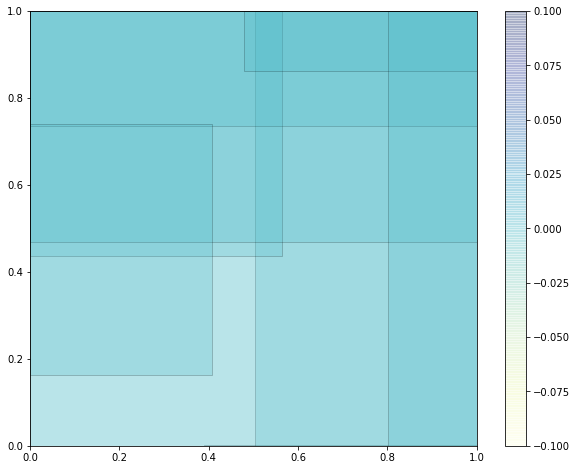

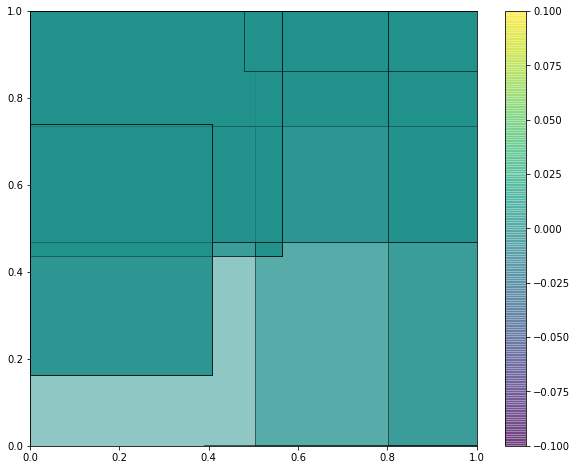

In [9]:
from shapely.geometry import box
from shapely.geometry.collection import GeometryCollection

# make some rectangles (for demonstration purposes and intersect with each other)

def get_rectangles(patches):
    rectangles = []
    for patch in patches:
        rect = box(patch[0][0], patch[1][0], patch[0][0]+patch[0][1], patch[1][0]+patch[1][1])
        rectangles.append(rect)
    return rectangles


def get_intersections(rectangles):
    """
    Iterate over every combination of rectangles and get the set of intersection rectangles.
    """
    omegas = []
    intersections = []
    for i, rect1 in enumerate(rectangles):
        for j, rect2 in enumerate(rectangles):
            intersection = rect1.intersection(rect2)
            if intersection not in intersections:
                if isinstance(intersection, GeometryCollection):
                    continue
                else:
                    omegas.append(RBP.omegas[i] + RBP.omegas[j])
                    intersections.append(intersection)
    return intersections, omegas


def plot_intersections():    
    from matplotlib.patches import Polygon
    from matplotlib.cm import ScalarMappable
    
    # Create figure and axes
    fig, ax = plt.subplots(1, figsize=(10,8))
        
    rectangles = get_rectangles(RBP.patchPara)
    intersections, omegas = get_intersections(rectangles)
    
    # Create patch collection with specified colour/alpha
    pc = PatchCollection([Polygon(a.exterior) for a in intersections], alpha=0.5)
    
    pc.set_array(np.array(omegas))
    pc.set_edgecolor('black')
    fig.colorbar(pc)
        
    # Add collection to axes
    ax.add_collection(pc)
    
    plt.show()
    
def geopandas_colorbar_same_height(f, ax, vmin=-2, vmax=12, cmap='viridis'):
    from matplotlib.colors import Normalize
    from matplotlib import cm
    from mpl_toolkits.axes_grid1 import make_axes_locatable

    # Create colorbar
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.4)

    norm = Normalize(vmin=vmin, vmax=vmax)
    n_cmap = cm.ScalarMappable(norm=norm, cmap=cmap)
    n_cmap.set_array([])

    f.colorbar(n_cmap, cax=cax)
    

def get_partitions(patches,omegas):
    import geopandas as gpd
    from shapely.geometry import Polygon
    
    def rect(patch): 
        rect = box(patch[0][0],
                   patch[1][0],
                   patch[0][0]+patch[0][1],
                   patch[1][0]+patch[1][1])
        return rect
    
    rect_df = gpd.GeoDataFrame({'geometry':[rect(patches[0])],'df1':[1.0]})
    for i,patch in enumerate(patches[1:]):
        # add rectangle and get intersections
        rect_df = gpd.overlay(rect_df, 
                              gpd.GeoDataFrame({'geometry':[rect(patch)],'df{}'.format(i+1):[1]}), 
                              how='union')
    rect_df['values'] = (np.dot(omegas, np.nan_to_num(rect_df.filter(regex='^df').values).T))
    return rect_df


def plot_partitions(fig, ax):
    from mpl_toolkits.axes_grid1 import make_axes_locatable
#     fig, ax = plt.subplots(1, 1, figsize=(fig[0],fig[1]*1.03))
    
    df_overlay = get_partitions(RBP.patchPara,RBP.omegas)
    df_overlay.plot(column='values',
                    ax=ax,
                    alpha=1, 
                    cmap='viridis'
                   )
#     geopandas_colorbar_same_height(fig,ax)

plot_patches()
plot_intersections()

(4, 4)
Expected number of boxes is: 10
============= Iteration 10 finished. =============
Number of boxes is: 7
time: 0.10
test rmse: 3.78
============= Iteration 50 finished. =============
Number of boxes is: 13
time: 0.90
test rmse: 3.76
============= Iteration 100 finished. =============
Number of boxes is: 15
time: 2.15
test rmse: 1.32
============= Iteration 1000 finished. =============
Number of boxes is: 4
time: 8.55
test rmse: 3.35
Expected number of boxes is: 10
============= Iteration 10 finished. =============
Number of boxes is: 15
time: 0.12
test rmse: 1.93
============= Iteration 50 finished. =============
Number of boxes is: 18
time: 1.42
test rmse: 2.60
============= Iteration 100 finished. =============
Number of boxes is: 21
time: 3.68
test rmse: 1.74
============= Iteration 1000 finished. =============
Number of boxes is: 21
time: 18.26
test rmse: 4.83
Expected number of boxes is: 10
============= Iteration 10 finished. =============
Number of boxes is: 10
time: 0.08

<Figure size 432x288 with 0 Axes>

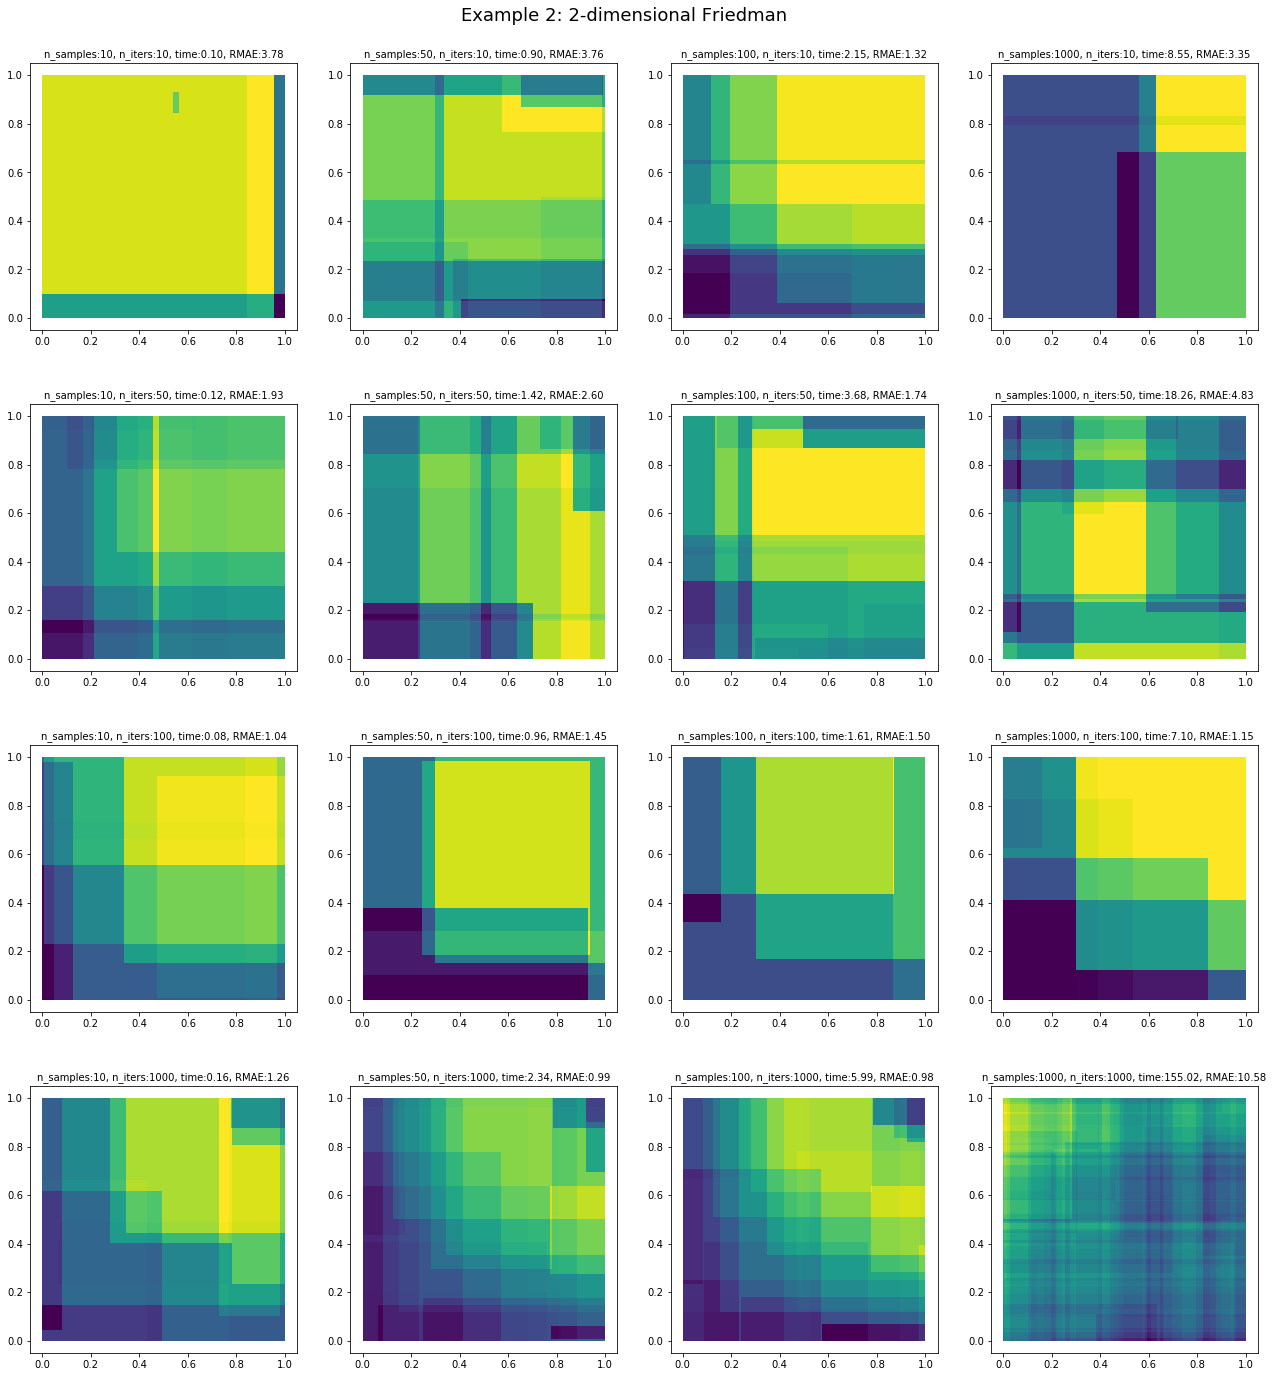

In [15]:
import time
import matplotlib.pyplot as plt

# plt.subplots_adjust(top=0.95)
plt.subplots_adjust(hspace=0.2)

probes=[10,50,100,1000]
samples=[10,50,100,1000]

# init plot
fig, axes = plt.subplots(nrows=len(probes), ncols=len(samples), figsize = (22,22))
fig.suptitle('Example 2: 2-dimensional Friedman', size=18)
plt.subplots_adjust(top=0.95)

print(axes.shape)
plot_num = 1

# iterate over samples
for sample in samples:
    xdata,ydata = friedman(dimNum, sample)
    
    # Split the data into train and test with ratio 50/50
    train_test_ratio = 0.5 # the ratio of test data

    # preprocess data
    (xdata_train, ydata_train,              # training set
    xdata_test, ydata_test,                 # testing set
    ydata_train_mean, dd,                   # mean
    hyper_sigma_1, hyper_sigma_2,           # variance of the prior
    variance_hat) = pre_process_data(xdata, ydata, train_test_ratio) # expected variance

    # the length vector for all the dimensions
    dimLength = np.ones(dimNum)*1.0

    # number of iterations to run algorithm
    IterationTime = 1000

    # Initialise the RBP
    RBP = PartitionPatch(dimLength, dataNum, taus, lambdas, np.mean(ydata_train), variance_hat)

    # patchnum = int(taus * np.prod(1 + lambdas * dimLength))
    print('Expected number of boxes is: '+str(RBP.patchNum))

    IterationTime = 1000

    predicted_value_train_seq = np.zeros((IterationTime, len(ydata_train)))
    predicted_value_test_seq = np.zeros((IterationTime, len(ydata_test)))
    train_RMAE_seq = np.zeros(IterationTime)
    test_RMAE_seq = np.zeros(IterationTime)
    Numbox = np.zeros(IterationTime)
    
    start = time.time()
    
    # iterate over model fit time
    for tt in range(IterationTime):
        RBP.Metropolis_Hastings_omegas(xdata_train, ydata_train)
        RBP.Metropolis_Hastings_A(xdata_train, ydata_train)
        RBP.hyperparameter_update(xdata_train, ydata_train, hyper_sigma_1, hyper_sigma_2)
        RBP.sample_patchNum(xdata_train, ydata_train)
        
        stop = time.time()
        tvals_train = RBP.total_judge(xdata_train)
        predicted_value_train_seq[tt] = np.dot(tvals_train, RBP.omegas)
        tvals_test = RBP.total_judge(xdata_test)
        predicted_value_test_seq[tt] = np.dot(tvals_test, RBP.omegas)

        train_RMAE_seq[tt] = np.mean(abs(predicted_value_train_seq[tt]-ydata_train)*dd)
        test_RMAE_seq[tt] = np.mean(abs(predicted_value_test_seq[tt]-ydata_test)*dd)
        Numbox[tt] = RBP.patchNum
    #     if np.mod(tt+1, 100)==0: # elementwise modulus operator
        if tt+1 in probes:
            print('============= Iteration '+str(tt+1) + ' finished. =============')
            print('Number of boxes is: '+ str(RBP.patchNum))
            print("time: {:.2f}".format(stop-start))
            print("test rmse: {:.2f}".format(test_RMAE_seq[tt]))
            
            ax1 = (int(np.floor((plot_num - 1)/len(probes))))
            ax2 = ((plot_num - 1) % len(samples))
            plot_partitions(fig, axes[ax1][ax2])
            
            # Add labels and titles
#             plt.xlabel('number of components')
#             plt.ylabel('cumulative explained variance');            
            axes[ax1][ax2].set_title('n_samples:{}, n_iters:{}, time:{:.2f}, RMAE:{:.2f}'.format(
                samples[ax2],probes[ax1],stop-start,test_RMAE_seq[tt]), size=10)
            
            plot_num += 1
            
plt.show()
fig.savefig('toy_example_1.png')

In [16]:
fig.savefig('toy_example_2.png')

In [ ]:
final_RMAE_train = np.mean(abs(
    np.mean(predicted_value_train_seq[int(IterationTime/2):,:], axis=0).reshape(-1)
            - ydata_train.reshape(-1)) * dd)

final_RMAE_test = np.mean(abs(
    np.mean(predicted_value_test_seq[int(IterationTime/2):,:], axis=0).reshape(-1)
            - ydata_test.reshape(-1)) * dd)

print('RBP-RT last train: '+str(train_RMAE_seq[-1])+', test: '+str(test_RMAE_seq[-1]))
print('RBP-RT train: '+str(final_RMAE_train)+', test: '+str(final_RMAE_test))

In [ ]:
plt.plot(train_RMAE_seq)
plt.plot(test_RMAE_seq)
plt.legend(['Train', 'Test'])
plt.show()